# Digit Recognizer: Handwritten Digit Classification

## Introduction

The Digit Recognizer problem is a classic machine learning task where we need to identify handwritten digits (0-9) from the famous MNIST dataset or its variations. This notebook demonstrates how to build, train, and evaluate a model for this classification task.

**Dataset Overview:**
- **train.csv**: Contains labeled images of handwritten digits (0-9)
- **test.csv**: Contains unlabeled images for prediction

Each row in the dataset represents a 28x28 pixel grayscale image of a handwritten digit. Each pixel value is an integer between 0 (white/background) and 255 (black/foreground).

## 1. Setup and Import Libraries

Let's start by importing the necessary libraries for data analysis, visualization, and machine learning.

In [2]:
# Import required libraries
# To calculate complex data , arrays store , calcualteect
import numpy as np
# Read CSV Files
import pandas as pd
# Plot graphs ect visualize image data ect
import matplotlib.pyplot as plt
# Extension of above , make graphs asthetic
import seaborn as sns
# ML Library of python
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For deep learning by google 
import tensorflow as tf
# TO add Layers like Conv2D and Dense , put layers together as a Model
from tensorflow.keras import layers, models
# Convert Labels into hot encoded vectors 
from tensorflow.keras.utils import to_categorical

# Set plotting style clean and modern look 
plt.style.use('fivethirtyeight')
# ensures plot appears inside the notebook
%matplotlib inline

# Display versions
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

NumPy Version: 2.1.3
Pandas Version: 2.2.3
TensorFlow Version: 2.19.0


## 2. Data Loading and Exploration

Next, we'll load the training and testing datasets, and explore their structure and contents.

In [8]:
# Reads a CSV file into a Pandas DataFrame.
# This makes it easy to view, sort, filter, and manipulate the data.

# Load the training data
train_data = pd.read_csv('train.csv')

# Load the test data
test_data = pd.read_csv('test.csv')

# Display Row and coloums of the data frames 
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

# Show first 5 rows so we can have a preview 
train_data.head()
# test_data.head()

Training data shape: (42000, 785)
Testing data shape: (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Data Preprocessing

In this section, we'll prepare our data for modeling by:
1. Separating features (pixel values) from the target variable (digit label)
2. Normalizing the pixel values (0-255 → 0-1)
3. Reshaping the data into the format expected by our model

In [14]:
# Separate features and target from training data
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

# Get test features
X_test = test_data.values

# Normalize pixel values to 0-1 range
X_train = X_train / 255.0
X_test = X_test / 255.0

# Check data shapes after preprocessing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Final training data shape: {X_train_final.shape}")
print(f"Validation data shape: {X_val.shape}")

X_train shape: (42000, 784)
y_train shape: (42000,)
X_test shape: (28000, 784)
Final training data shape: (33600, 784)
Validation data shape: (8400, 784)
Final training data shape: (33600, 784)
Validation data shape: (8400, 784)


## 4. Data Visualization

Let's visualize some examples of the handwritten digits to better understand our data.

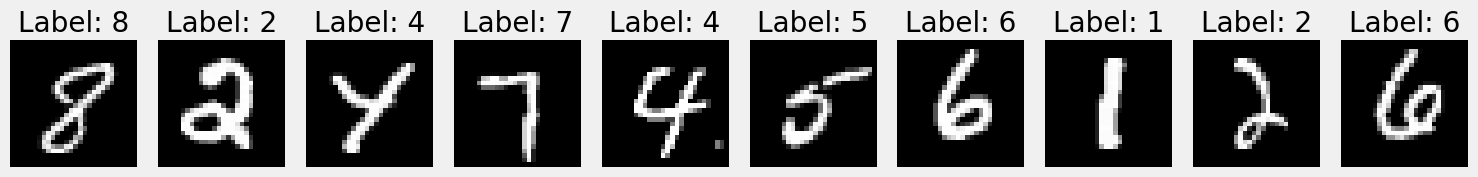

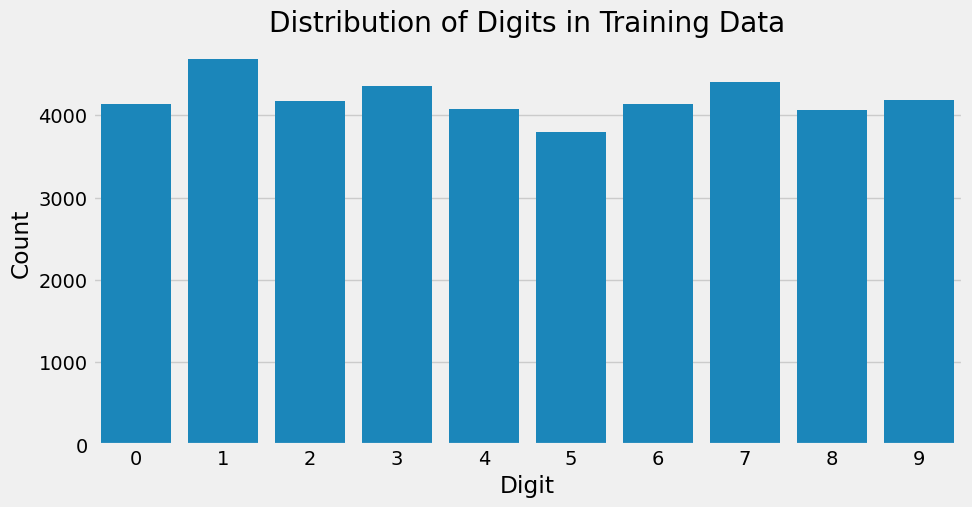

In [15]:
# Function to display multiple images
def display_digits(images, labels=None, predictions=None, n=10):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        # Reshape image to 28x28 pixels
        img = images[i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if labels is not None:
            title = f"Label: {labels[i]}"
            if predictions is not None:
                title += f"\nPred: {predictions[i]}"
            plt.title(title)
    plt.tight_layout()
    plt.show()

# Display some training examples
random_indices = np.random.randint(0, X_train_final.shape[0], 10)
display_digits(X_train_final[random_indices], y_train_final[random_indices])

# Visualize the distribution of digits in the training set
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Distribution of Digits in Training Data')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

## 5. Model Building

We can approach this problem with different models. Let's start with a Convolutional Neural Network (CNN), which is very effective for image classification tasks.

In [ ]:
# Reshape data for CNN input (add channel dimension)
X_train_cnn = X_train_final.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)

# One-hot encode target variables
y_train_cnn = to_categorical(y_train_final, 10)
y_val_cnn = to_categorical(y_val, 10)

# Build CNN model
def build_cnn_model():
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and display model summary
cnn_model = build_cnn_model()
cnn_model.summary()

## 6. Model Training

Now let's train our CNN model on the training data and monitor its performance on the validation set.

In [ ]:
# Train the model
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=20,
    batch_size=128,
    validation_data=(X_val_cnn, y_val_cnn),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our model's performance on the validation set.

In [ ]:
# Evaluate the model on validation data
val_loss, val_acc = cnn_model.evaluate(X_val_cnn, y_val_cnn, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Get predictions
y_pred = cnn_model.predict(X_val_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cnn, axis=1)

# Display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Display some example predictions
random_indices = np.random.randint(0, X_val_cnn.shape[0], 10)
display_digits(
    X_val_cnn[random_indices].reshape(-1, 28*28), 
    y_true[random_indices], 
    y_pred_classes[random_indices]
)

## 8. Make Predictions on Test Data

Finally, let's use our trained model to make predictions on the test data.

In [ ]:
# Reshape test data for CNN input
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Make predictions on test data
test_predictions = cnn_model.predict(X_test_cnn)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Display some test predictions
display_indices = np.random.randint(0, X_test_cnn.shape[0], 10)
display_digits(X_test_cnn[display_indices].reshape(-1, 28*28), predictions=test_predictions_classes[display_indices])

# Create submission file
submission = pd.DataFrame({
    'ImageId': range(1, len(test_predictions_classes) + 1),
    'Label': test_predictions_classes
})

# Save submission file
submission.to_csv('digit_recognizer_submission.csv', index=False)
print("Submission file created!")
submission.head()

## 9. Conclusion and Further Improvements

In this notebook, we built a CNN model to recognize handwritten digits. Here are some potential improvements to consider:

1. **Data Augmentation**: Generate more training samples by applying rotations, shifts, and other transformations to existing images
2. **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, and network architectures
3. **Ensemble Methods**: Combine predictions from multiple models for better accuracy
4. **Other Model Architectures**: Try other approaches like Random Forests, SVM, or advanced CNN architectures like ResNet

Thank you for following along with this digit recognition project!